In [1]:
%load_ext autoreload
%autoreload 2

### 1. Load MIRIAD Dataset

In [2]:
import torchvision.transforms as transforms
from miriad import MiriadDataset
import torch

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))]
)

batch_size=4

train_dataset = MiriadDataset(root="data/miriad", train=True, transform=transform, crop=0.75)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
val_dataset = MiriadDataset(root="data/miriad", train=False, transform=transform, crop=0.75)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

classes = ('HC', 'AD')

train_dataset[0][0].size()

torch.Size([1, 31, 64, 64])

torch.Size([4, 1, 31, 64, 64])


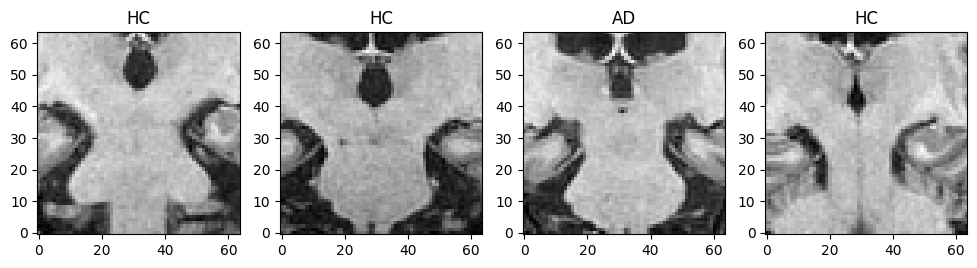

In [3]:
import matplotlib.pyplot as plt

# get some random training images
dataiter = iter(train_loader)
mris, labels = next(dataiter)

print(mris.size())

plt.figure(figsize=(12, 6))
i = 0
for sample_data, sample_label in zip(mris, labels):
    mri_sample_slice = sample_data[0, 16, :, :]
    plt.subplot(1, batch_size, i+1)  # Create a subplot for each sample
    plt.imshow(mri_sample_slice.T, cmap='gray', origin='lower')
    plt.title(f"{classes[sample_label]}")  # Display the label as the title
    i += 1
plt.show()

### 2. 3D-CNN Classification Model

In [7]:
from models import AlzheimersClassification3DCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
print(device)

model = AlzheimersClassification3DCNN().double().to(device)
print(model)

cuda
AlzheimersClassification3DCNN(
  (_conv_layers): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (4): ReLU()
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(16, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1))
    (7): ReLU()
    (8): AdaptiveMaxPool3d(output_size=(4, 4, 4))
  )
  (_fc1): Linear(in_features=2048, out_features=256, bias=True)
  (_fc2): Linear(in_features=256, out_features=1, bias=True)
)


In [8]:
from tqdm.auto import tqdm

# training
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        labels = labels.float()

        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)

        print(f"Loss = {loss.item()}")
        
        train_running_loss += loss.item()
        # calculate the accuracy
        preds = (outputs > 0.5).float()
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)

            labels = labels.float()

            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            preds = (outputs > 0.5).float()
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [9]:
# training configuration
import torch.optim as optim
import torch.nn as nn

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
epochs = 3

In [10]:
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_loader,  
                                                criterion)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

[INFO]: Epoch 1 of 3
Training


  0%|          | 0/80 [00:00<?, ?it/s]

: 

: 

In [23]:
# overfit to single sample
data = next(iter(train_loader))

for epoch in range(epochs):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    labels = labels.float()

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    print(loss.item())

print('Finished Training')
model.eval()

with torch.no_grad():

    prediction = nn.Sigmoid()(model(data[0]))
    actual = data[1]

    print(f"Predicted class {classes[int(prediction)]} - Expected class {classes[int(prediction)]}")

0.0
0.0
0.0
Finished Training
Predicted class AD - Expected class AD


In [ ]:
# TODO: move to cuda
# TODO: initialize random weights
# TODO: train on full dataset
# TODO: visualize with tensorboard